In [ ]:
!pip install wandb

In [ ]:
import wandb
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
wandb.init(
    project="hw1",
    config={"batch_size": 32, "epochs": 10, "learning_rate": 0.01},
)


config = wandb.config

train_loss,█▅▄▄▃▃▂▂▁▁
val_loss,█▄▃▂▂▂▁▁▂▂
train_loss,0.35139
val_loss,0.82674


In [ ]:
config

{'batch_size': 32, 'epochs': 10, 'learning_rate': 0.01}

# Домашняя работа №1

Датасет: CIFAR-10

CIFAR-10 — это популярный набор данных, который содержит 60,000 изображений размером 32x32 пикселей, разделенных на 10 классов. Каждый класс включает 6,000 изображений. Изображения в датасете имеют 3 канала (RGB), и все они принадлежат к 10 категориям:

1. airplane — самолеты <br>
2. automobile — автомобили <br>
3. bird — птицы <br>
4. cat — кошки <br>
5. deer — олени <br>
6. dog — собаки <br>
7. frog — лягушки <br>
8. horse — лошади <br>
9. ship — корабли <br>
10. truck — грузовики <br>

Модель: ResNet-18

ResNet (Residual Network) — это архитектура нейронной сети, которая использует остаточные блоки (residual blocks), чтобы облегчить обучение глубоких сетей, предотвращая проблему затухающего градиента. Архитектура была представлена в 2015 году в статье "Deep Residual Learning for Image Recognition" (Kaiming He и др.).

В ResNet используются короткие соединения (skip connections), которые помогают градиентам "перепрыгивать" через несколько слоев, что значительно ускоряет обучение и улучшает точность.

В данном примере для CIFAR-10 можно использовать ResNet-18, так как она достаточно легкая и эффективная для этой задачи.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support
import wandb
from torchvision import datasets, models
import numpy as np


class_names = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]

transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

trainset = datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform
)
testset = datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform
)

trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=config.batch_size, shuffle=True
)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=config.batch_size, shuffle=False
)

model = models.resnet18(weights=None)
model.fc = nn.Linear(model.fc.in_features, 10)
model = model.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# Функция для оценки модели
@torch.no_grad()
def evaluate(model, dataloader):
    model.eval()
    val_loss = 0
    all_labels = []
    all_preds = []
    for images, labels in dataloader:
        images, labels = images.cuda(), labels.cuda()
        outputs = model(images)
        loss = criterion(outputs, labels)
        val_loss += loss.item()
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(outputs.argmax(dim=1).cpu().numpy())
    val_loss /= len(dataloader)
    return val_loss, all_labels, all_preds


# Тренировка модели
for epoch in range(config.epochs):
    model.train()
    running_loss = 0.0
    for images, labels in trainloader:
        images, labels = images.cuda(), labels.cuda()

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_loss = running_loss / len(trainloader)

    # Оценка на валидационном наборе
    val_loss, all_labels, all_preds = evaluate(model, testloader)

    # Расчет метрик
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average=None, labels=range(10)
    )
    overall_precision, overall_recall, overall_f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average="weighted"
    )

    # Логирование метрик в wandb
    metrics = {
        "epoch": epoch + 1,
        "train_loss": train_loss,
        "val_loss": val_loss,
        "overall_precision": overall_precision,
        "overall_recall": overall_recall,
        "overall_f1": overall_f1,
    }

    # Логируем метрики для каждого класса отдельно
    for i, class_name in enumerate(class_names):
        metrics[f"precision_{class_name}"] = precision[i]
        metrics[f"recall_{class_name}"] = recall[i]
        metrics[f"f1_{class_name}"] = f1[i]

    wandb.log(metrics)

    print(
        f"Epoch [{epoch + 1}/{config.epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}"
    )

Epoch [1/10], Train Loss: 1.7218, Val Loss: 1.3398
Epoch [2/10], Train Loss: 1.2053, Val Loss: 1.0671
Epoch [3/10], Train Loss: 0.9766, Val Loss: 0.9212
Epoch [4/10], Train Loss: 0.8315, Val Loss: 0.8800
Epoch [5/10], Train Loss: 0.7163, Val Loss: 0.7753
Epoch [6/10], Train Loss: 0.6202, Val Loss: 0.8399
Epoch [7/10], Train Loss: 0.5317, Val Loss: 0.9084
Epoch [8/10], Train Loss: 0.4480, Val Loss: 0.7783
Epoch [9/10], Train Loss: 0.3729, Val Loss: 0.8032
Epoch [10/10], Train Loss: 0.3080, Val Loss: 0.8619


In [ ]:
# Функция для оценки модели
@torch.no_grad()
def evaluate(model, dataloader):
    model.eval()
    val_loss = 0
    all_labels = []
    all_preds = []
    for images, labels in dataloader:
        images, labels = images.cuda(), labels.cuda()
        outputs = model(images)
        loss = criterion(outputs, labels)
        val_loss += loss.item()
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(outputs.argmax(dim=1).cpu().numpy())

    # Средняя потеря
    val_loss /= len(dataloader)

    # Расчет метрик для каждого класса (точность, полнота, F1)
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average=None, labels=range(10)
    )

    return val_loss, precision, recall, f1


# После завершения обучения, например, после всех эпох:
model.eval()  # Переводим модель в режим оценки (выключает Dropout, BatchNorm)
val_loss, precision, recall, f1 = evaluate(model, testloader)

# Выводим метрики для каждого класса
print("Metrics for each class:")
for i, class_name in enumerate(class_names):
    print(
        f"{class_name} - Precision: {precision[i]:.4f}, Recall: {recall[i]:.4f}, F1: {f1[i]:.4f}"
    )

Metrics for each class:
airplane - Precision: 0.7797, Recall: 0.8210, F1: 0.7998
automobile - Precision: 0.8543, Recall: 0.8500, F1: 0.8521
bird - Precision: 0.7431, Recall: 0.6420, F1: 0.6888
cat - Precision: 0.5668, Recall: 0.4410, F1: 0.4961
deer - Precision: 0.8076, Recall: 0.6340, F1: 0.7104
dog - Precision: 0.5406, Recall: 0.7530, F1: 0.6293
frog - Precision: 0.7873, Recall: 0.8290, F1: 0.8076
horse - Precision: 0.7658, Recall: 0.8370, F1: 0.7998
ship - Precision: 0.8394, Recall: 0.8780, F1: 0.8583
truck - Precision: 0.8330, Recall: 0.7830, F1: 0.8072


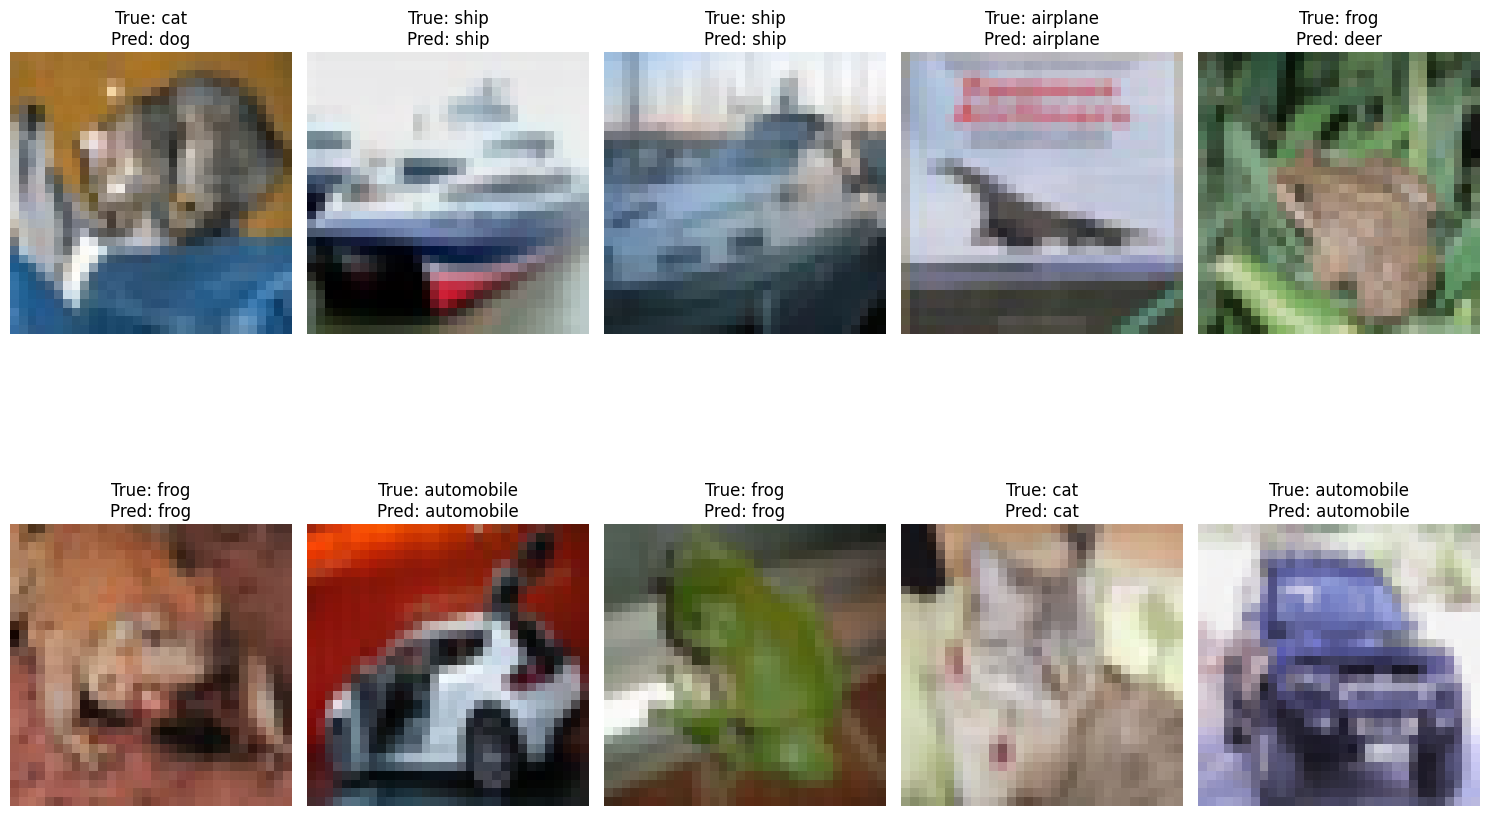

In [ ]:
@torch.no_grad()
def visualize_predictions(model, dataloader, num_images=10):
    model.eval()
    images_shown = 0
    plt.figure(figsize=(15, 15))

    for images, labels in dataloader:
        images, labels = images.cuda(), labels.cuda()
        outputs = model(images)
        preds = outputs.argmax(dim=1)

        for i in range(images.size(0)):
            if images_shown >= num_images:
                break

            image = images[i].cpu().numpy().transpose((1, 2, 0))
            image = np.clip(
                image * np.array([0.229, 0.224, 0.225])
                + np.array([0.485, 0.456, 0.406]),
                0,
                1,
            )
            label = class_names[labels[i].item()]
            pred = class_names[preds[i].item()]

            plt.subplot(num_images // 5 + 1, 5, images_shown + 1)
            plt.imshow(image)
            plt.title(f"True: {label}\nPred: {pred}")
            plt.axis("off")
            images_shown += 1

        if images_shown >= num_images:
            break

    plt.tight_layout()
    plt.show()


visualize_predictions(model, testloader, num_images=10)